In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix



In [72]:
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
train_directory = './archive/chest_xray/train'
val_directory = './archive/chest_xray/val'
test_directory = './archive/chest_xray/test'

In [74]:
for folder in [train_directory, val_directory, test_directory]:
    print(f"\n{folder.upper()}: Set")
    for label in ['NORMAL', 'PNEUMONIA']:
        print(f"{label}: {len(os.listdir(os.path.join(folder, label)))}")


./ARCHIVE/CHEST_XRAY/TRAIN: Set
NORMAL: 1341
PNEUMONIA: 3875

./ARCHIVE/CHEST_XRAY/VAL: Set
NORMAL: 8
PNEUMONIA: 8

./ARCHIVE/CHEST_XRAY/TEST: Set
NORMAL: 234
PNEUMONIA: 390


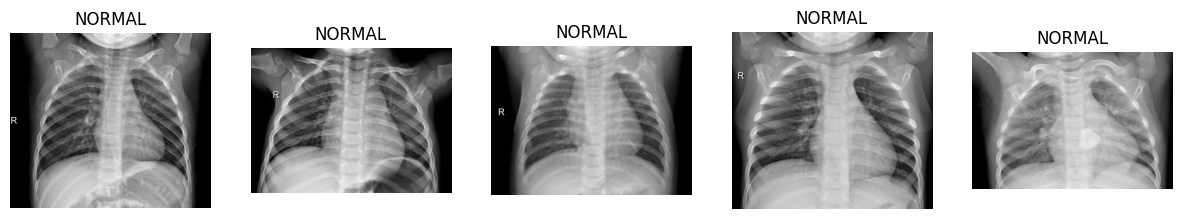

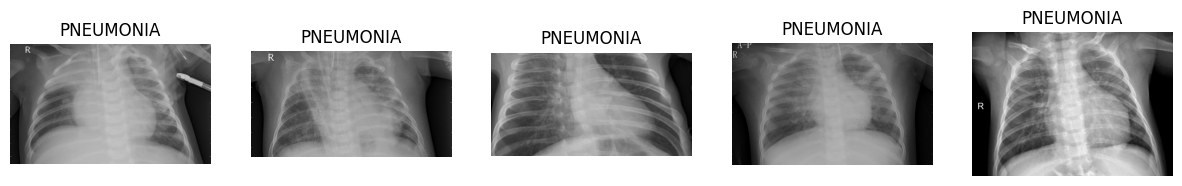

In [75]:
import random
from PIL import Image

def show_samples(directory, label, num_images=5):
    images = os.listdir(os.path.join(directory, label))
    samples = random.sample(images, num_images)
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(directory, label, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

show_samples(train_directory, 'NORMAL')
show_samples(train_directory, 'PNEUMONIA')


In [76]:

img_size = (150, 150)


train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val = ImageDataGenerator(rescale=1./255)

train_data = train.flow_from_directory(
    train_directory,
    target_size=img_size,
    class_mode='binary',
    batch_size=32
)

val_data = val.flow_from_directory(
    val_directory,
    target_size=img_size,
    class_mode='binary',
    batch_size=32
)

test_data = val.flow_from_directory(
    test_directory,
    target_size=img_size,
    class_mode='binary',
    batch_size=32,
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [77]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\USER\OneDrive\Desktop\New folder\tenserflow intro\testenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
from sklearn.utils.class_weight import compute_class_weight


train_normal = len(os.listdir(os.path.join(train_directory, 'NORMAL')))
train_pneumonia = len(os.listdir(os.path.join(train_directory, 'PNEUMONIA')))


y_train = [0] * train_normal + [1] * train_pneumonia


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)


class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [79]:
stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[stop],
    class_weight=class_weight_dict
)


c:\Users\USER\OneDrive\Desktop\New folder\tenserflow intro\testenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.5352 - loss: 0.6878 - val_accuracy: 0.6875 - val_loss: 0.6499
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8237 - loss: 0.3855 - val_accuracy: 0.8125 - val_loss: 0.3056
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.8931 - loss: 0.2465 - val_accuracy: 0.7500 - val_loss: 0.4329
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.8979 - loss: 0.2434 - val_accuracy: 0.7500 - val_loss: 0.5751
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9259 - loss: 0.1865 - val_accuracy: 0.8125 - val_loss: 0.3005
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 986ms/step - accuracy: 0.9246 - loss: 0.1847 - val_accuracy: 0.8125 - val_loss: 0.3124
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9184 - loss: 0.1934 - val_accuracy: 0.9375 - val_loss: 0.2808
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.9283 - loss: 0.1631 - val_a

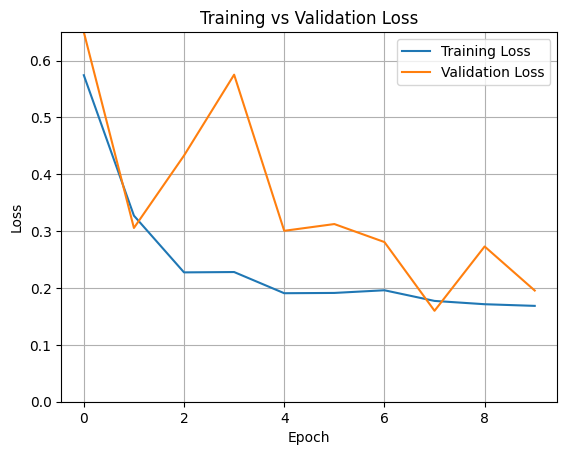

In [80]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'] + history.history['val_loss'])])
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()


In [81]:
loss,accuracy = model.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 519ms/step - accuracy: 0.8986 - loss: 0.2876


In [82]:
pred = model.predict(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 437ms/step


In [84]:
labels = test_data.classes

In [92]:

pred_labels = (pred > 0.5).astype("int32").flatten()
print(classification_report(labels, pred_labels, target_names=['NORMAL', 'PNEUMONIA']))


              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00       239
   PNEUMONIA       1.00      1.00      1.00       385

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624



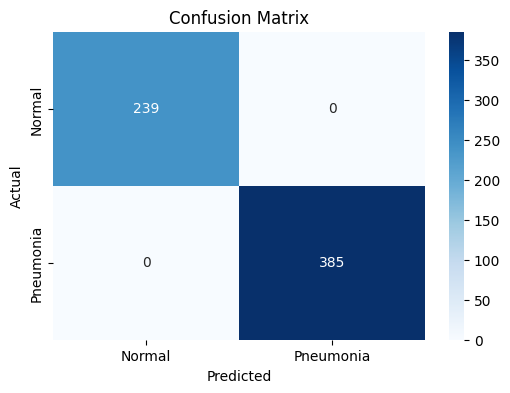

In [93]:
cm = confusion_matrix(labels, pred_labels)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()